# LSTM

This notebook was created before the .py runner, and is only kept to understand each step of this approach, but to run the different tests and read the code please use the runners.
The runner is up to date, this version is not. Additionally, results obtained in the report were obtained with the runners and not the notebooks

## Read data

In [31]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
import torch
from torchtune.datasets import ConcatDataset
import optuna
import lightning.pytorch as pl
from electricity_price_forecast.data.dataset import DatasetWithWindow
from electricity_price_forecast.model.lstm_model import LSTMModel
from electricity_price_forecast.model.torch_lightning_module import TorchLightningModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from electricity_price_forecast.data.datamodule import Datamodule
from electricity_price_forecast.data.data_visualization import plot_prices, plot_predictions_vs_real
import logging
from electricity_price_forecast.model.lstm_model import MULTI_STEP
from electricity_price_forecast.data.data_processing import transform_synthetic_data_optimized, preprocess_true_data, preprocess_synthetic_data, DataNormalizer, get_predict_data, get_splits

logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

VAL_RATIO = 0.2
TESTED_HORIZONS = [6, 12, 24, 48, 72, 168]

In [32]:
df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet")
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

print(df_price.index.min())
print(df_price.index.max())
df_price.head()

2016-12-31 23:00:00+00:00
2020-12-31 22:00:00+00:00


,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [33]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [34]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,58.82,2016-12-31 23:00:00+00:00,5,23,366,0,31,12,2016,0
1,58.23,2017-01-01 00:00:00+00:00,6,0,1,1,1,1,2017,1
2,51.95,2017-01-01 01:00:00+00:00,6,1,1,1,1,1,2017,2
3,47.27,2017-01-01 02:00:00+00:00,6,2,1,1,1,1,2017,3
4,45.49,2017-01-01 03:00:00+00:00,6,3,1,1,1,1,2017,4


In [35]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,31.66,2016-12-31 00:00:00+00:00,5,0,366,0,31,12,2016,0
1,31.06,2016-12-31 01:00:00+00:00,5,1,366,0,31,12,2016,1
2,27.81,2016-12-31 02:00:00+00:00,5,2,366,0,31,12,2016,2
3,27.54,2016-12-31 03:00:00+00:00,5,3,366,0,31,12,2016,3
4,25.04,2016-12-31 04:00:00+00:00,5,4,366,0,31,12,2016,4


## Plot data

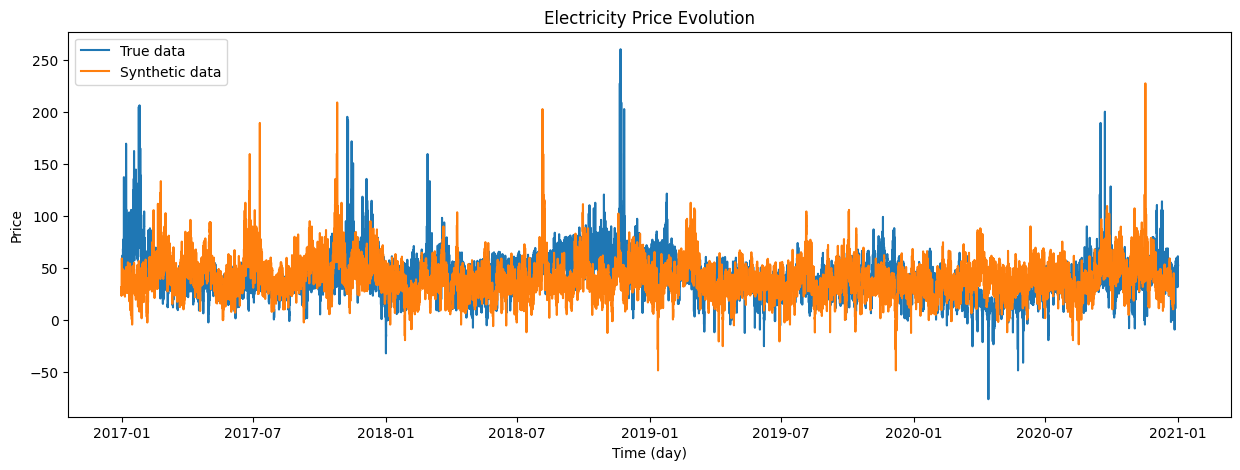

In [36]:
plot_prices([df_price_preprocessed, df_price_generated_00257_preprocessed], ["True data", "Synthetic data"])

## Training functions

In [37]:
def get_best_params(datamodule, horizon, n_trials=50):
    """Get the best hyperparameters for the model using Optuna.
    
    Args:
        datamodule (Datamodule): The datamodule to use for training.
        horizon (int): The horizon to forecast.
        n_trials (int): The number of trials to run.
    
    Returns:
        dict: The best hyperparameters.
    """
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: train_model(
        datamodule,
        horizon,
        lr=trial.suggest_float("lr", 1e-5, 1e-1),
        n_epochs=30,
        hidden_dim=trial.suggest_int("hidden_dim", 16, 512),
        n_layers=trial.suggest_int("n_layers", 1, 10),
    )[-1]["val_loss"], n_trials=n_trials)
    return study.best_params

def train_model(datamodule, horizon, early_stopping=False, lr=0.001, n_epochs=50, hidden_dim=32, n_layers=1, device="cuda"):
    """Train a model on the given datamodule and params
    
    Args:
        datamodule (Datamodule): The datamodule to use for training.
        horizon (int): The horizon to forecast.
        early_stopping (bool): Whether to use early stopping.
        lr (float): The learning rate.
        n_epochs (int): The number of epochs to train.
        hidden_dim (int): The hidden dimension of the LSTM.
        n_layers (int): The number of layers in the LSTM.
        device (str): The device to use for training.
    
    Returns:
        Tuple[LightningModule, dict]: The trained model and the training metrics.
    """
    train_dataloader = datamodule.train_dataloader()
    X_batch, _ = next(iter(train_dataloader))
    input_dim = X_batch.shape[-1]
    
    model_params = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "output_dim": horizon,
        "multi_step": MULTI_STEP.ALL_AT_ONCE
    }
    
    model = TorchLightningModule(LSTMModel, model_params, lr=lr, device=device)
    
    if early_stopping:
        callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=False)]
    else:
        callbacks = []
        
    if device == "cuda":
        trainer = pl.Trainer(max_epochs=n_epochs, devices=-1, accelerator="cuda", callbacks=callbacks, enable_checkpointing=False, logger=False)
    else:
        trainer = pl.Trainer(max_epochs=n_epochs, callbacks=callbacks, enable_checkpointing=False, logger=False)
    
    trainer.fit(model, datamodule)
            
    return model, {"val_loss": trainer.callback_metrics["val_loss"], "train_loss": trainer.callback_metrics["train_loss"]}

def eval_model(model, dataloader, device="cuda"):
    """Evaluate the model on the given dataloader.
    
    Args:
        model (LightningModule): The model to evaluate.
        dataloader (DataLoader): The dataloader to use for evaluation.
        device (str): The device to use for evaluation.
    Returns:
        dict: The evaluation metrics (mse, mae and rmse...)
    """
    predictions = []
    ground_truth = []
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            y_pred = model(X)
            predictions.append(y_pred)
            ground_truth.append(y)
    
    predictions = torch.cat(predictions).squeeze()
    ground_truth = torch.cat(ground_truth).squeeze()
    return TorchLightningModule.get_test_metrics(predictions, ground_truth)

def predict(model, x, device="cuda"):
    """Predict the output of the model for the given input.
    
    Args:
        model (LightningModule): The model to use for prediction.
        x (torch.Tensor): The input tensor.
        device (str): The device to use for prediction.
        
    Returns:
        torch.Tensor: The predicted output.
    """
    model.eval()
    model.to(device)
    y_pred = None
    
    with torch.no_grad():
        y_pred = model(x)
    
    return y_pred

## Without data augmentation

In [38]:
window_size = 12
window_step = min(TESTED_HORIZONS[4], window_size)
horizon = TESTED_HORIZONS[4]
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

# splits
train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [39]:
train_dataloader = datamodule.train_dataloader()
X_batch, y_batch = next(iter(train_dataloader))
print(len(train_dataloader))
print(X_batch.shape)
print(y_batch.shape)

69
torch.Size([32, 12, 6])
torch.Size([32, 72, 1])


#### Find best params

In [40]:
# best_params = get_best_params(datamodule, horizon, n_trials=50)

In [41]:
# best_params = {'lr': 0.00024273038278097014, 'hidden_dim': 352, 'n_layers': 2}
best_params = {'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}
# best_params = {'lr': 0.0008968772529225413, 'hidden_dim': 155, 'n_layers': 2}
best_params

{'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}

#### Train and eval

In [42]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   7%|▋         | 5/69 [00:00<00:00, 169.43it/s, train_loss=7.910]

Epoch 5: 100%|██████████| 69/69 [00:00<00:00, 162.95it/s, train_loss=7.170, val_loss=15.70]


100%|██████████| 6/6 [00:00<00:00, 857.32it/s]

Results: {'mse': 230.80221557617188, 'mae': 10.641348838806152, 'rmse': 15.19217586517334}


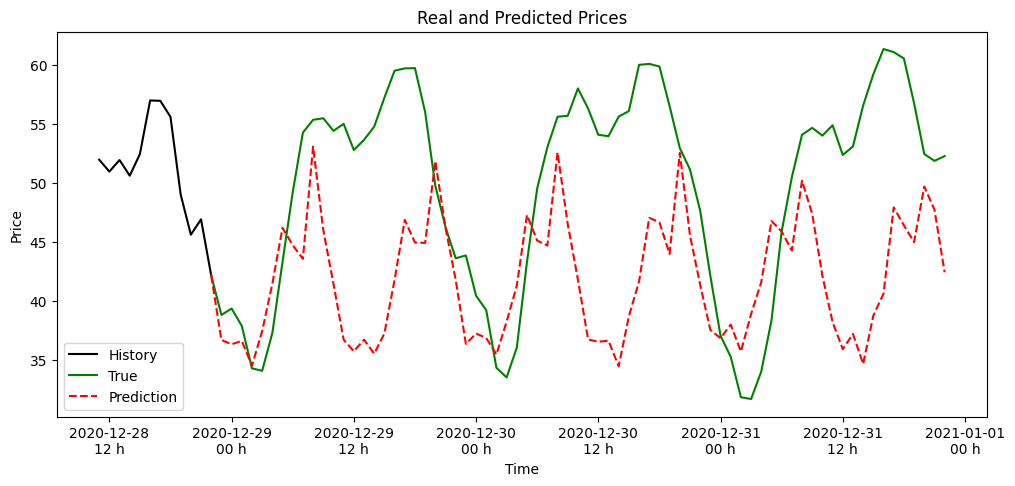

In [43]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions)

### With provided data augmentation (synthetic data)

In [44]:
def load_synthetic_datasets(path, window_size, window_step, horizon, max_num_fetched=None):
    """Load the synthetic datasets from the given path.
    
    Args:
        path (str): The path to the datasets.
        window_size (int): The window size.
        window_step (int): The window step.
        horizon (int): The horizon to forecast.
        max_num_fetched (int): The maximum number of datasets to fetch.
    
    Returns:
        List[DatasetWithWindow]: The synthetic datasets.
    """
    if max_num_fetched is not None and max_num_fetched < 0:
        max_num_fetched = None
    train_all = []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_num_fetched is not None and i >= max_num_fetched:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            train_all.append(DatasetWithWindow(df_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price"))
    
    return train_all

In [45]:
directory = "../data/scenarios synthetiques/prix/"
train_all = load_synthetic_datasets(directory, window_size, window_step, horizon, 10)

  6%|▋         | 10/154 [00:00<00:02, 64.93it/s]


In [46]:
train_concat = ConcatDataset(train_all)

train_split_size = int(len(train_concat)*(1-VAL_RATIO))
val_split_size = len(train_concat) - train_split_size

train_split, val_split, _ = get_splits(train_concat, 0, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split)

# test_split is the same (we don't want to test on synthetic data)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

#### Find best params

In [47]:
# best_params = get_best_params(datamodule, horizon, n_trials=20)

In [48]:
# best_params = {'lr': 0.00024273038278097014, 'hidden_dim': 352, 'n_layers': 2}
best_params = {'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}
# best_params = {'lr': 0.0008968772529225413, 'hidden_dim': 155, 'n_layers': 2}
best_params

{'lr': 0.07425688743431168, 'hidden_dim': 274, 'n_layers': 2}

In [49]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 8: 100%|██████████| 727/727 [00:04<00:00, 155.90it/s, train_loss=11.20, val_loss=12.60]


100%|██████████| 6/6 [00:00<00:00, 857.35it/s]

Results: {'mse': 252.70645141601562, 'mae': 11.3051176071167, 'rmse': 15.896743774414062}


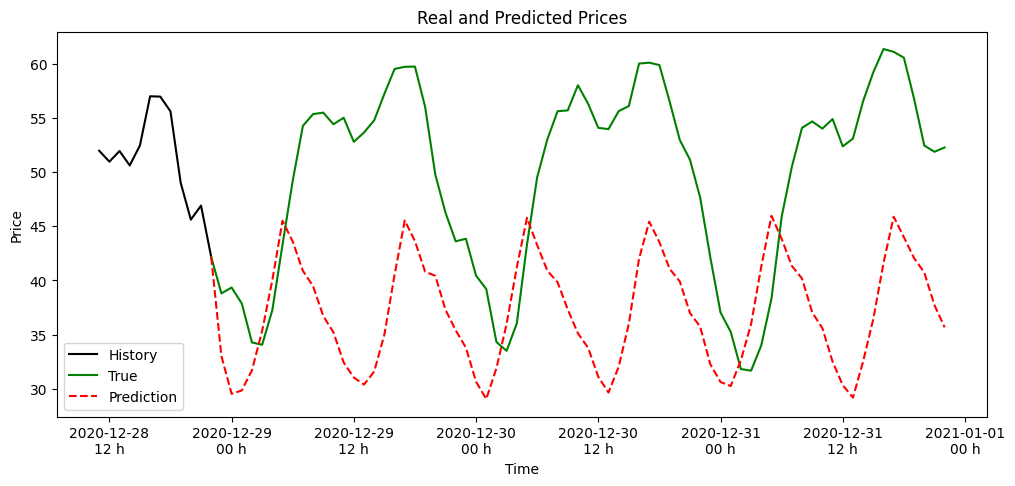

In [50]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions)

## With Normalization

In [51]:
data_normalizer = DataNormalizer()
df_price_preprocessed_normalized = data_normalizer.transform_df(df_price_preprocessed)
df_price_preprocessed_normalized.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,0.400989,2016-12-31 23:00:00+00:00,0.833333,1.000000,1.0,0.000000,1.0,1.0,0.00,0.000000
1,0.399232,2017-01-01 00:00:00+00:00,1.000000,0.000000,0.0,0.000684,0.0,0.0,0.25,0.000029
2,0.380528,2017-01-01 01:00:00+00:00,1.000000,0.043478,0.0,0.000684,0.0,0.0,0.25,0.000057
3,0.366590,2017-01-01 02:00:00+00:00,1.000000,0.086957,0.0,0.000684,0.0,0.0,0.25,0.000086
4,0.361289,2017-01-01 03:00:00+00:00,1.000000,0.130435,0.0,0.000684,0.0,0.0,0.25,0.000114


In [52]:
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed_normalized, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)
predict_dates, predict_y, predict_x = get_predict_data(test_split)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [53]:
# best_params = get_best_params(datamodule, horizon, n_trials=50)

In [54]:
best_params = {'lr': 0.04576315047600192, 'hidden_dim': 30, 'n_layers': 8}
best_params

{'lr': 0.04576315047600192, 'hidden_dim': 30, 'n_layers': 8}

In [55]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 69/69 [00:00<00:00, 152.54it/s, train_loss=0.0602, val_loss=0.0829]


100%|██████████| 6/6 [00:00<00:00, 1000.11it/s]

Results: {'mse': 0.0037831091322004795, 'mae': 0.05081676319241524, 'rmse': 0.061506982892751694}


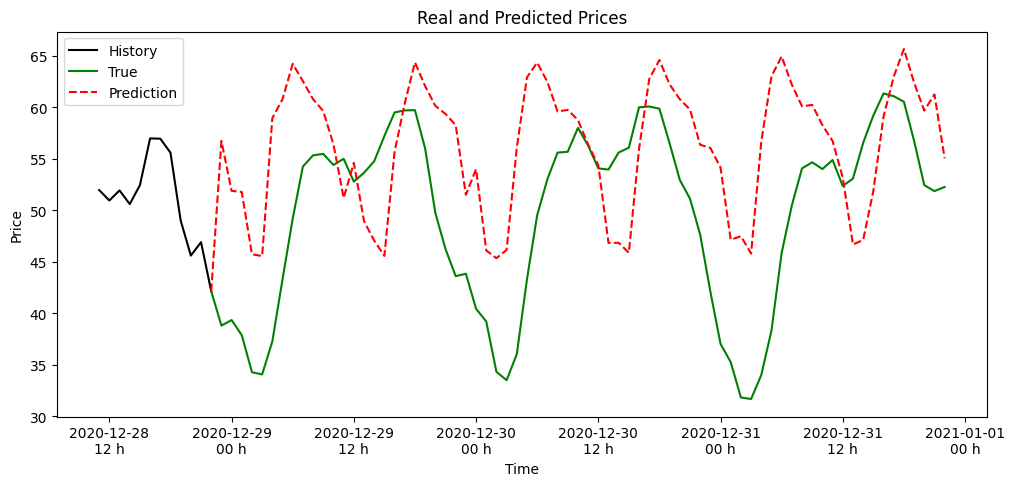

In [56]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions, data_normalizer)